# Train the BiVAE on 2 styles of Maptiles
- with style accuracy metric
- Jan 23, 2021

## Load libraries

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
import os,sys
import re
import math
from datetime import datetime
import time
sys.dont_write_bytecode = True

In [6]:
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from typing import List, Set, Dict, Tuple, Optional, Iterable, Mapping, Union, Callable, TypeVar

from pprint import pprint
from ipdb import set_trace as brpt

In [7]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from  torch.linalg import norm as tnorm
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import datasets, transforms

import pytorch_lightning as pl
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.tuner.tuning import Tuner
from pytorch_lightning.callbacks import Callback



# Select Visible GPU
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

## Set Path 
1. Add project root and src folders to `sys.path`
2. Set DATA_ROOT to `maptile_v2` folder

In [8]:
this_nb_path = Path(os.getcwd())
ROOT = this_nb_path.parent
SRC = ROOT/'src'
DATA_ROOT = Path("/data/hayley-old/maptiles_v2/")
paths2add = [this_nb_path, ROOT]

print("Project root: ", str(ROOT))
print('Src folder: ', str(SRC))
print("This nb path: ", str(this_nb_path))


for p in paths2add:
    if str(p) not in sys.path:
        sys.path.insert(0, str(p))
        print(f"\n{str(p)} added to the path.")
        
# print(sys.path)

Project root:  /data/hayley-old/Tenanbaum2000
Src folder:  /data/hayley-old/Tenanbaum2000/src
This nb path:  /data/hayley-old/Tenanbaum2000/nbs

/data/hayley-old/Tenanbaum2000 added to the path.


In [9]:
from src.data.transforms.transforms import Identity, Unnormalizer, LinearRescaler
from src.data.transforms.functional import unnormalize

from src.visualize.utils import show_timg, show_timgs, show_batch, make_grid_from_tensors
from src.utils.misc import info, get_next_version_path, n_iter_per_epoch
from src.utils.scheduler import frange_cycle_linear
from collections import OrderedDict


## Start experiment 
Given a maptile, predict its style as one of OSM, CartoVoyager

In [10]:
# # For reproducibility, set seed like following:
# seed = 100
# pl.seed_everything(seed)
# # sets seeds for numpy, torch, python.random and PYTHONHASHSEED.
# model = Model()
# trainer = pl.Trainer(deterministic=True)

## Adversarial model

TODO:

---
### For batch in dataloader:
- x: (BS, C, h, w): a mini-batch of (c,h,w) tensor

### mu, log_var = model.encoder(x) 
- mu: (BS, latent_dim)
- log_var: (BS, latent_dim)

### z = model.rsample(mu, log_var, self.n_samples) 
- z: (BS, n_samples, latent_dim)
-`z[n]` constains `n_samples` number of latent codes, sampled from the same distribution `N(mu[n], logvar[n])`
 
### recon = model.decoder(z) 
- recon: (BS, n_samples, c, h, w)
- `recon[n]` contains `n_samples` number of (c,h,w)-sized $mu_{x}$, corresponding to the center of the factorized Gaussian for the latent code $z^{(n,l)}$ ($l$th z_sample from $N(\mu[n], logvar[n])$, ie. $\mu_{x}^{(n,l)}$

### out = model.forward(x)
- out (dict): keys are "mu", "logvar", "recon"

### loss_dict = loss_function(out, x, self.n_samples)
- loss_dict (dict): keys are "loss", "kl", "recon_loss"
- kl is computed the same way as in the Vanillia_VAE model's `loss_function`
- recon_loss is a generalized version with `self.n_samples` (>=1) number of samples to estimated each datapoint's MSE_loss as the average over the loss's from the `n_samples` number of $z_{n,l}$ samples.


In [11]:
# from src.data.datamodules import MNISTDataModule, MNISTMDataModule, MonoMNISTDataModule
# from src.data.datamodules import MultiMonoMNISTDataModule
# from src.data.datamodules.multisource_rotated_mnist_datamodule import MultiRotatedMNISTDataModule
from src.data.datamodules.multisource_maptiles_datamodule import MultiMaptilesDataModule
from src.models.plmodules.bilatent_vae import BiVAE

## DataModule configs


In [12]:
# Init MNIST-M DataModule
# data_root = ROOT/'data'
# in_shape = (3,32,32)
# batch_size = 32
# dm = MNISTMDataModule(
#     data_root=data_root, 
#     in_shape=in_shape,
#     batch_size=batch_size)
# dm.setup('fit')
# # show_batch(dm, cmap='gray')

In [13]:
# # Init Monochrome datamodule
# color='green'
# n_styles = 1
# colorstr_transform = transforms.Lambda(lambda color_name: 0)
# dm = MonoMNISTDataModule(
#     data_root=Path('/data/hayley-old/Tenanbaum2000/data/Mono-MNIST/'),
#     color=color,
#     seed=123,
#     colorstr_transform=colorstr_transform,
#     in_shape=in_shape,
#     batch_size=batch_size
# )
# dm.setup('fit')

# # Show a batch
# dl = dm.train_dataloader()
# sample = next(iter(dl))
# x = sample['img']
# c_label = sample['digit']
# s_label = sample['color']
# show_timgs(x)
# print("Content labels: ", c_label) #digit-id
# print("Style labels: ", s_label) #color
# print("===")


In [14]:
# # Init Multisource-Monochrome MNIST datamodule
# mono_dir = ROOT/'data/Mono-MNIST'
# colors = ['red', 'green', 'blue']
# seed = 123
# in_shape = (3,32,32)
# batch_size = 128

# # Create a multi-source dataset
# dm = MultiMonoMNISTDataModule(
#     data_root=mono_dir,
#     colors=colors,
#     seed=seed,
#     in_shape=in_shape,
#     batch_size=batch_size,
#     shuffle=True,
# )
# dm.setup('fit')

# # Show a batch
# # dl = dm.train_dataloader()
# # sample = next(iter(dl))
# # x = sample['img']
# # c_label = sample['digit']
# # s_label = sample['color']
# # show_timgs(x)
# # print("Content labels: ", c_label) #digit-id
# # print("Style labels: ", s_label) #color
# # print("===")


In [15]:
# # Init Multisource-Rotated MNIST datamodule
# # Dataset settings
# data_dir = Path("/data/hayley-old/Tenanbaum2000/data/")
# angles = [45, 0, -45] # [-45, 0, 45] # [-60, -15, 15, 60]
# seed = 123
# in_shape = (1, 32, 32)
# batch_size = 32

# # Create a multisource rotated-mnist datamodule
# dm = MultiRotatedMNISTDataModule(
#     data_root=data_dir,
#     angles=angles,
#     in_shape=in_shape,
#     batch_size=batch_size,
#     shuffle=True,
#     split_seed=seed,
# )
# dm.setup('fit')

# # Show a batch
# print(dm.name)
# dl = dm.train_dataloader()
# batch = next(iter(dl))
# x, label_c, label_s = dm.unpack(batch)
# show_timgs(x, cmap='gray')
# print(label_c)
# print(label_s)
# print("===")

In [20]:
dm.styles


['StamenTonerBackground']

Unique styles:  ['StamenTonerBackground']
Unique styles:  ['StamenTonerBackground']
Unique styles:  ['StamenTonerBackground']
n_train, n_val:  3941 1688
train channelwise_mean,std:  [0.86216066] [0.3307773]
shape:  torch.Size([32, 1, 64, 64])
dtype:  torch.float32
min, max:  -2.606469 0.4164112
['8751-6086', '2814-6539', '4519-6473', '8790-5385', '2804-6544', '4838-5851', '13702-6663', '8798-5371', '13734-6677', '13972-6341', '13696-6715', '13711-6698', '13727-6677', '4199-6089', '13738-6665', '2812-6537', '4843-5860', '13719-6685', '4829-5851', '13714-6701', '2811-6550', '13698-6707', '8757-6084', '4199-6100', '13708-6687', '8788-5380', '4840-5866', '4513-6479', '13726-6701', '13971-6342', '13704-6708', '13694-6686']
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


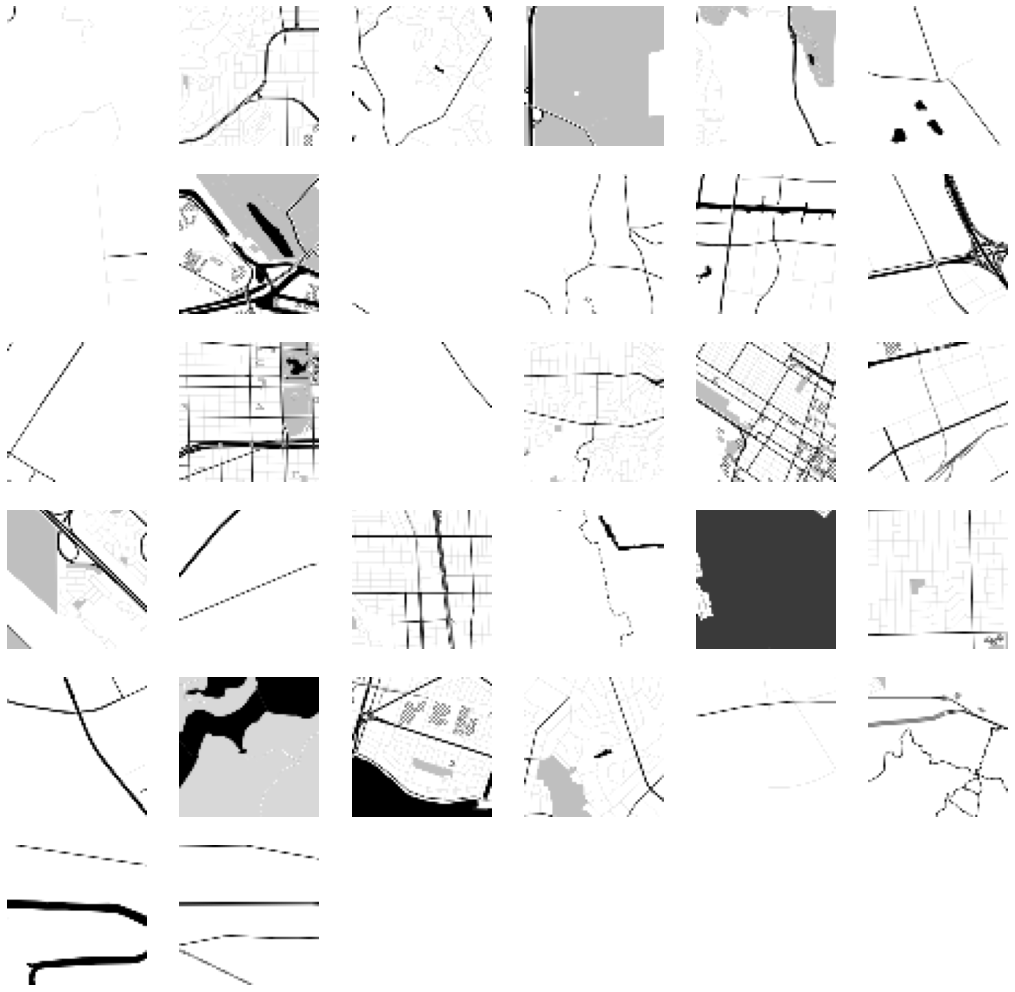

In [16]:
# Instantiate Multisource Maptiles DataModule
all_cities = ['la', 'charlotte', 'vegas', 'boston', 'paris', \
              'amsterdam', 'shanghai', 'seoul', 'chicago', 'manhattan', \
             'berlin', 'montreal', 'rome']

data_root = Path("/data/hayley-old/maptiles_v2/")
cities = all_cities #['berlin', 'rome', 'la', 'amsterdam', 'seoul'] #['paris']
styles = ['StamenTonerBackground'] #'OSMDefault', 'CartoVoyagerNoLabels']#'StamenWatercolor']#, 'StamenTonerLines']
zooms = ['14']
in_shape = (1, 64, 64)
batch_size = 32

dm = MultiMaptilesDataModule(
    data_root=data_root,
    cities=cities,
    styles=styles,
    zooms=zooms,
    in_shape=in_shape,
    batch_size=batch_size,
)
dm.setup('fit')

# show a batch
dl = dm.train_dataloader()
batch = next(iter(dl))
x, label_c, label_s = dm.unpack(batch)
info(x)
show_timgs(x, cmap='gray')
print(label_c)
print(label_s)

In [18]:
# Init plModule
latent_dim = 10
hidden_dims = [32,32,64,64,128,256] #,512]
lr = 3e-4
act_fn = nn.ReLU()
# Specific for BiVAE
adversary_dims = [32,32,32] 
is_contrasive = True # If true, use adv. loss from both content and style codes. Else just style codes
kld_weight = 1.0 # vae_loss = recon_loss + kld_weight * kld_weight
adv_loss_weight = 15. # loss = vae_loss + adv_loss_weight * adv_loss

model = BiVAE(
    in_shape=dm.size(), 
    n_styles=dm.n_styles,
    latent_dim=latent_dim,
    hidden_dims=hidden_dims,
    adversary_dims=adversary_dims,
    learning_rate=lr, 
    act_fn=act_fn,
    size_average=False,
    is_contrasive=is_contrasive,
    kld_weight=kld_weight,
    adv_loss_weight=adv_loss_weight,
)

# model
    

In [19]:
# Model wrapper from graph viz
from src.models.model_wrapper import ModelWrapper
# Add Callbacks
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from src.callbacks.hist_logger import HistogramLogger
from src.callbacks.recon_logger import ReconLogger
from src.callbacks.beta_scheduler import BetaScheduler

# n_epoch
max_epochs = 100
max_iters = n_iter_per_epoch(dm.train_dataloader()) * max_epochs
callbacks = [
    BetaScheduler(max_iters)
#         HistogramLogger(hist_epoch_interval=1),
#         ReconLogger(recon_epoch_interval=1),
#         EarlyStopping('val_loss', patience=10),
]

# Start the experiment
exp_name = f'{model.name}_{dm.name}'
tb_logger = pl_loggers.TensorBoardLogger(save_dir=f'{ROOT}/temp-logs', 
                                         name=exp_name,
                                         log_graph=False,
                                        default_hp_metric=False)
print("Log dir: ", tb_logger.log_dir)

log_dir = Path(tb_logger.log_dir)
if not log_dir.exists():
    log_dir.mkdir(parents=True)
    print("Created: ", log_dir)
    

# Log computational graph
# model_wrapper = ModelWrapper(model)
# tb_logger.experiment.add_graph(model_wrapper, model.example_input_array.to(model.device))
# tb_logger.log_graph(model)

trainer_config = {
    'gpus':1,
    'max_epochs': max_epochs,
    'progress_bar_refresh_rate':0,
#     'auto_lr_find': True,
    'terminate_on_nan':True,
#     'num_sanity_val_steps':0.25,
    'check_val_every_n_epoch':10,
    'logger':tb_logger,
    'callbacks':callbacks,
}

# 
# trainer = pl.Trainer(fast_dev_run=3)
trainer = pl.Trainer(**trainer_config)
# trainer.tune(model=model, datamodule=dm)

# Start exp
# Fit model
trainer.fit(model, dm)
print(f"Finished at ep {trainer.current_epoch, trainer.batch_idx}")

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Log dir:  /data/hayley-old/Tenanbaum2000/temp-logs/BiVAE-C_Maptiles_la-charlotte-vegas-boston-paris-amsterdam-shanghai-seoul-chicago-manhattan-berlin-montreal-rome_StamenTonerBackground_14/version_2
Created:  /data/hayley-old/Tenanbaum2000/temp-logs/BiVAE-C_Maptiles_la-charlotte-vegas-boston-paris-amsterdam-shanghai-seoul-chicago-manhattan-berlin-montreal-rome_StamenTonerBackground_14/version_2


/home/hayley/miniconda3/envs/test/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: RuntimeWarning: Found unsupported keys in the lr scheduler dict: ['name']
  warnings.warn(*args, **kwargs)

  | Name               | Type       | Params
--------------------------------------------------
0 | act_fn             | ReLU       | 0     
1 | encoder            | Sequential | 435 K 
2 | fc_flatten2qparams | Linear     | 5.1 K 
3 | fc_latent2decoder  | Linear     | 2.8 K 
4 | decoder            | Sequential | 434 K 
5 | final_layer        | Sequential | 301   
6 | adversary          | Sequential | 2.3 K 
7 | train_style_acc    | Accuracy   | 0     
8 | val_style_acc      | Accuracy   | 0     
9 | test_style_acc     | Accuracy   | 0     
--------------------------------------------------
879 K     Trainable params
0         Non-trainable params
879 K     Total params
/home/hayley/miniconda3/envs/test/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: siz

Ep: 0, batch: 0
Ep: 0, batch: 0
Ep: 0, batch: 0
Ep: 10, batch: 0
Ep: 20, batch: 0
Ep: 30, batch: 0
Ep: 40, batch: 0
Ep: 50, batch: 0
Ep: 60, batch: 0
Ep: 70, batch: 0
Ep: 80, batch: 0
Ep: 90, batch: 0
Finished at ep (99, 123)


In [21]:
model.current_epoch, model.logger.log_dir

(99,
 '/data/hayley-old/Tenanbaum2000/temp-logs/BiVAE-C_Maptiles_la-charlotte-vegas-boston-paris-amsterdam-shanghai-seoul-chicago-manhattan-berlin-montreal-rome_StamenTonerBackground_14/version_2')

## Log  hparmeters and `best_score` to tensorboard

In [22]:
hparams = model.hparams.copy()
hparams.update(dm.hparams)
best_score = trainer.checkpoint_callback.best_model_score.item()
metrics = {'hparam/best_score': best_score} #todo: define a metric and use it here
pprint(hparams)
pprint(metrics)

{'act_fn': ReLU(),
 'adv_loss_weight': 15.0,
 'adversary_dims': [32, 32, 32],
 'batch_size': 32,
 'cities': ['la',
            'charlotte',
            'vegas',
            'boston',
            'paris',
            'amsterdam',
            'shanghai',
            'seoul',
            'chicago',
            'manhattan',
            'berlin',
            'montreal',
            'rome'],
 'hidden_dims': [32, 32, 64, 64, 128, 256],
 'in_shape': (1, 64, 64),
 'is_contrasive': True,
 'kld_weight': 1.0,
 'latent_dim': 10,
 'learning_rate': 0.0003,
 'n_contents': 13,
 'n_styles': 1,
 'size_average': False,
 'source_names': ['StamenTonerBackground'],
 'styles': ['StamenTonerBackground'],
 'zooms': ['14']}
{'hparam/best_score': 57353.6015625}


In [23]:
# Use pl.Logger's method "log_hyperparameters" which handles the 
# hparams' element's formats to be suitable for Tensorboard logging
# See: 
# https://sourcegraph.com/github.com/PyTorchLightning/pytorch-lightning@be3e8701cebfc59bec97d0c7717bb5e52afc665e/-/blob/pytorch_lightning/loggers/tensorboard.py#explorer:~:text=def%20log_hyperparams
best_score = trainer.checkpoint_callback.best_model_score.item()
metrics = {'hparam/best_score': best_score} #todo: define a metric and use it here
trainer.logger.log_hyperparams(hparams, metrics)

 TODO:
 OPTIMIZER
 def configure_optimizers(self):
        #TODO: ADD optimizer for discriminator
        return torch.optim.Adam(self.parameters(), lr=self.hparams.get("learning_rate"))

## TODO: 
Showing the changes in the scores based on c and scores based on s will be super intersting to see as the model learns!!!

# Evaluations

In [24]:
from src.models.plmodules.utils import get_best_ckpt, load_model, load_best_model
from pytorch_lightning.utilities.cloud_io import load as pl_load


Load best model recorded during the training


In [25]:
ckpt_path = get_best_ckpt(model, verbose=True)
ckpt = pl_load(ckpt_path, map_location=lambda storage, loc: storage)  # dict object
print(ckpt['epoch'])

'epoch:90'
'global_step:11160'
'pytorch-lightning_version:1.1.0'
'callbacks'
("{<class 'pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint'>: "
 "{'monitor': 'val_loss', 'best_model_score': tensor(57353.6016), "
 "'best_model_path': "
 "'/data/hayley-old/Tenanbaum2000/temp-logs/BiVAE-C_Maptiles_la-charlotte-vegas-boston-paris-amsterdam-shanghai-seoul-chicago-manhattan-berlin-montreal-rome_StamenTonerBackground_14/version_2/checkpoints/epoch=89-step=11159.ckpt', "
 "'current_score': tensor(57353.6016)}}")
("lr_schedulers:[{'factor': 0.1, 'min_lrs': [0], 'patience': 10, 'verbose': "
 "True, 'cooldown': 0, 'cooldown_counter': 0, 'mode': 'min', 'threshold': "
 "0.0001, 'threshold_mode': 'rel', 'best': 57744.640625, 'num_bad_epochs': 9, "
 "'mode_worse': inf, 'eps': 1e-08, 'last_epoch': 89, '_last_lr': [0.0003]}]")
'hparams_name:kwargs'
'hyper_parameters'
("{'in_shape': (1, 64, 64), 'n_styles': 1, 'latent_dim': 10, 'hidden_dims': "
 "[32, 32, 64, 64, 128, 256], 'adversary_dims': [

In [26]:
# Load bestmodel
model.load_state_dict(ckpt['state_dict'])


<All keys matched successfully>

## Reconstruction
    
    

In [27]:
from torch.utils.tensorboard import SummaryWriter

def show_recon(model: BiVAE, 
               tb_writer: SummaryWriter=None,
               global_step:int=0,
               unnorm:bool=True, 
               to_show:bool=True, 
               verbose:bool=False):
    model.eval()
    dm = model.trainer.datamodule
    cmap = 'gray' if dm.size()[0] ==1 else None
    train_mean, train_std = dm.train_mean, dm.train_std
    with torch.no_grad():
        for mode in ['train', 'val']:
            dl = getattr(model, f"{mode}_dataloader")()
            batch = next(iter(dl))
            
            x = batch['img']
#             label_c = batch['digit']  # digit/content label (int) -- currently not used
#             label_s = batch['color']
            x = x.to(model.device)
            x_recon = model.generate(x)
            
            # Move to cpu for visualization
            x = x.cpu()
            x_recon = x_recon.cpu()
            
            if verbose: 
                info(x, f"{mode}_x")
                info(x_recon, f"{mode}_x_recon")
                
            if unnorm:
                x_unnormed = unnormalize(x, train_mean, train_std)
                x_recon_unnormed = unnormalize(x_recon, train_mean, train_std)
                if verbose:
                    print("===After unnormalize===")
                    info(x_unnormed, f"{mode}_x_unnormed")
                    info(x_recon_unnormed, f"{mode}_x_recon_unnormed")
                    
            if to_show:
                _x = x_unnormed if unnorm else x
                _x_recon = x_recon_unnormed if unnorm else x_recon
                show_timgs(_x, title=f"Input: {mode}", cmap=cmap)
#                 show_timgs(_x_recon, title=f"Recon: {mode}", cmap=cmap)
                show_timgs(LinearRescaler()(_x_recon), title=f"Recon(linearized): {mode}", cmap=cmap)

            # Log input-recon grid to TB
            if tb_writer is not None:
                input_grid = torchvision.utils.make_grid(x_unnormed) # (C, gridh, gridw)
                recon_grid = torchvision.utils.make_grid(x_recon_unnormed) # (C, gridh, gridw)
                normed_recon_grid = torchvision.utils.make_grid(LinearRescaler()(x_recon_unnormed))
                
                grid = torch.cat([input_grid, normed_recon_grid], dim=-1) #inputs | recons
                tb_writer.add_image(f"{mode}/recons", grid, global_step=global_step)


train_x
shape:  torch.Size([32, 1, 64, 64])
dtype:  torch.float32
min, max:  -2.606469 0.4164112
train_x_recon
shape:  torch.Size([32, 1, 64, 64])
dtype:  torch.float32
min, max:  -0.9541169 0.8745763
===After unnormalize===
train_x_unnormed
shape:  torch.Size([32, 1, 64, 64])
dtype:  torch.float32
min, max:  -7.886345e-08 0.9999
train_x_recon_unnormed
shape:  torch.Size([32, 1, 64, 64])
dtype:  torch.float32
min, max:  0.54656047 1.1514506
val_x
shape:  torch.Size([32, 1, 64, 64])
dtype:  torch.float32
min, max:  -2.606469 0.4164112
val_x_recon
shape:  torch.Size([32, 1, 64, 64])
dtype:  torch.float32
min, max:  -0.9541169 0.74711615
===After unnormalize===
val_x_unnormed
shape:  torch.Size([32, 1, 64, 64])
dtype:  torch.float32
min, max:  -7.886345e-08 0.9999
val_x_recon_unnormed
shape:  torch.Size([32, 1, 64, 64])
dtype:  torch.float32
min, max:  0.54656047 1.1092896


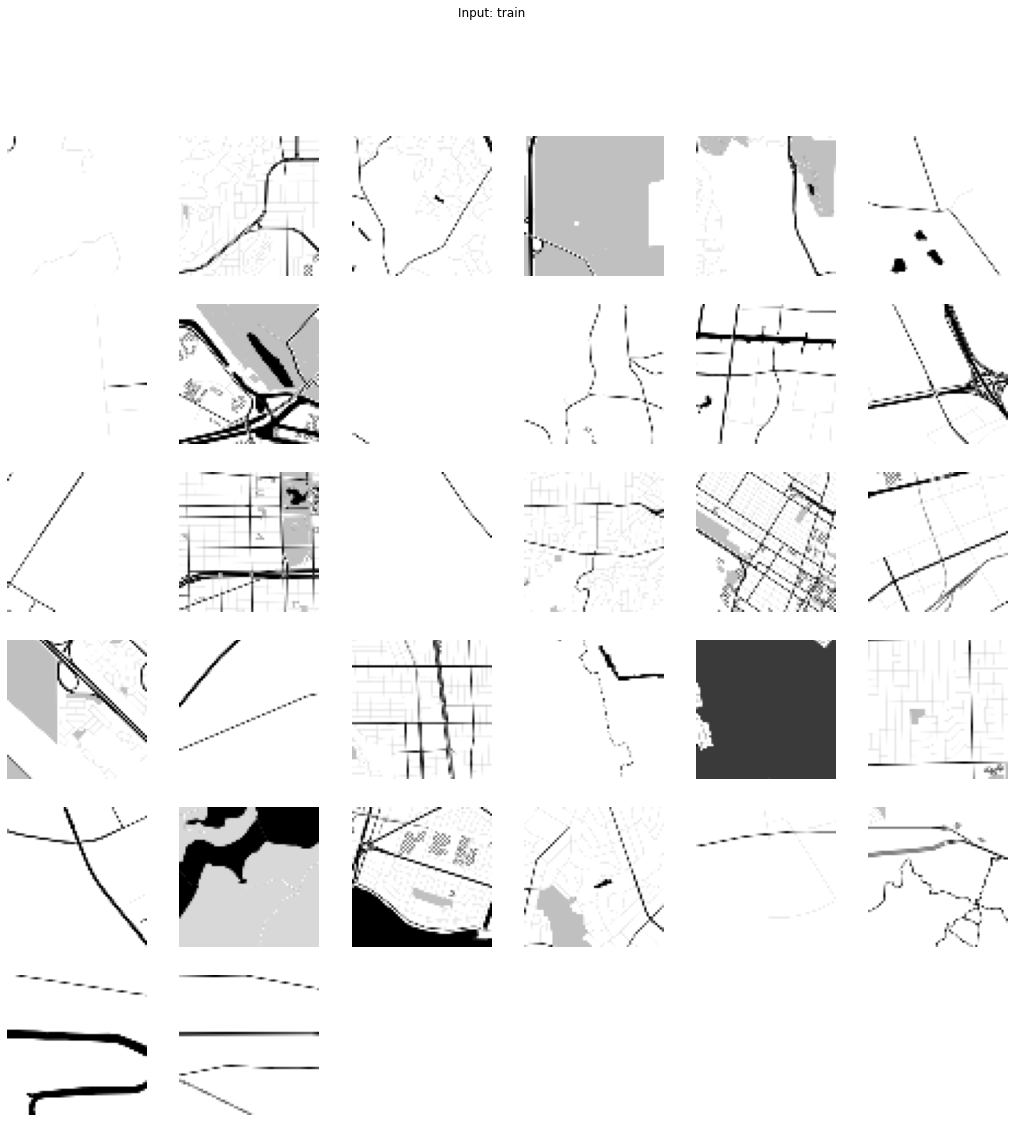

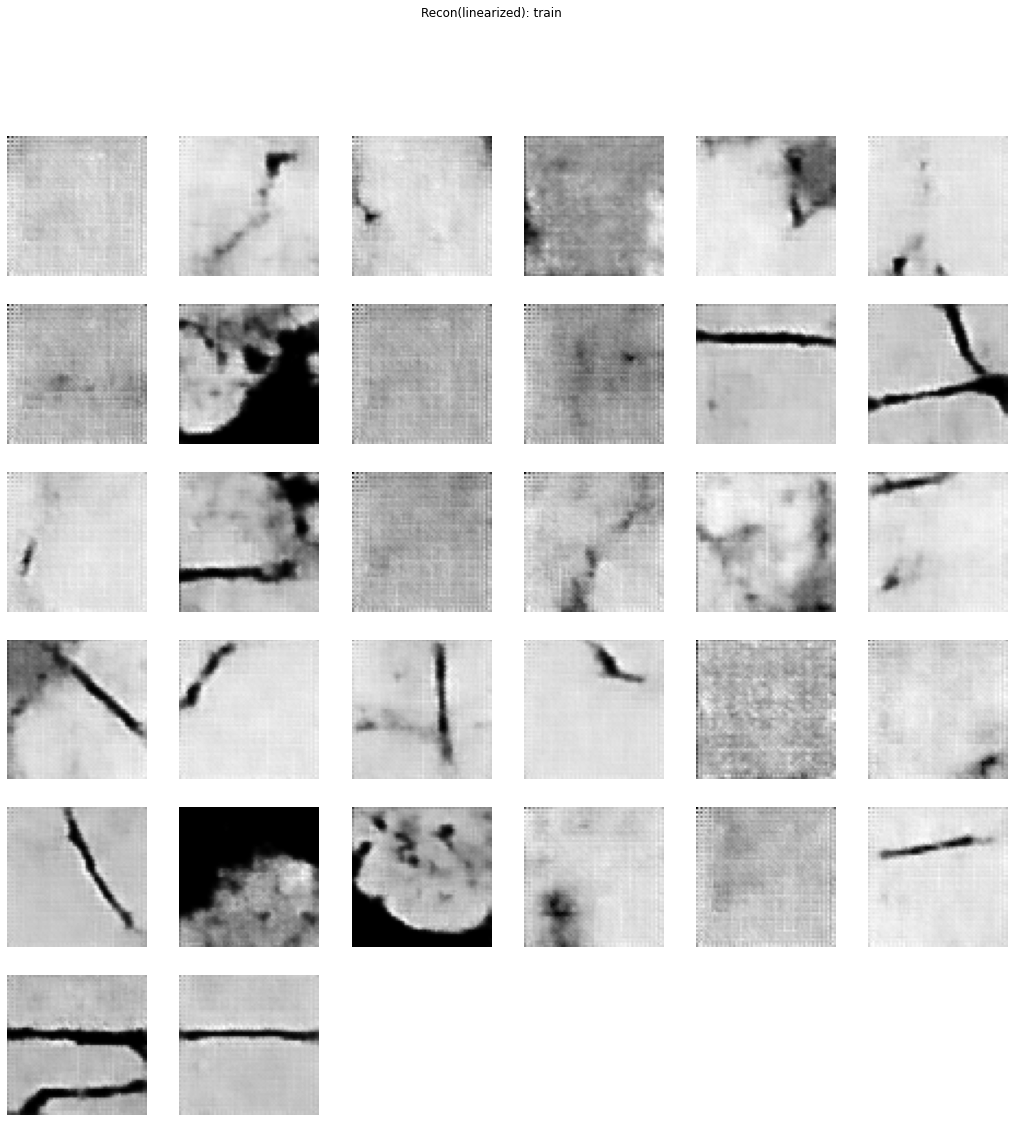

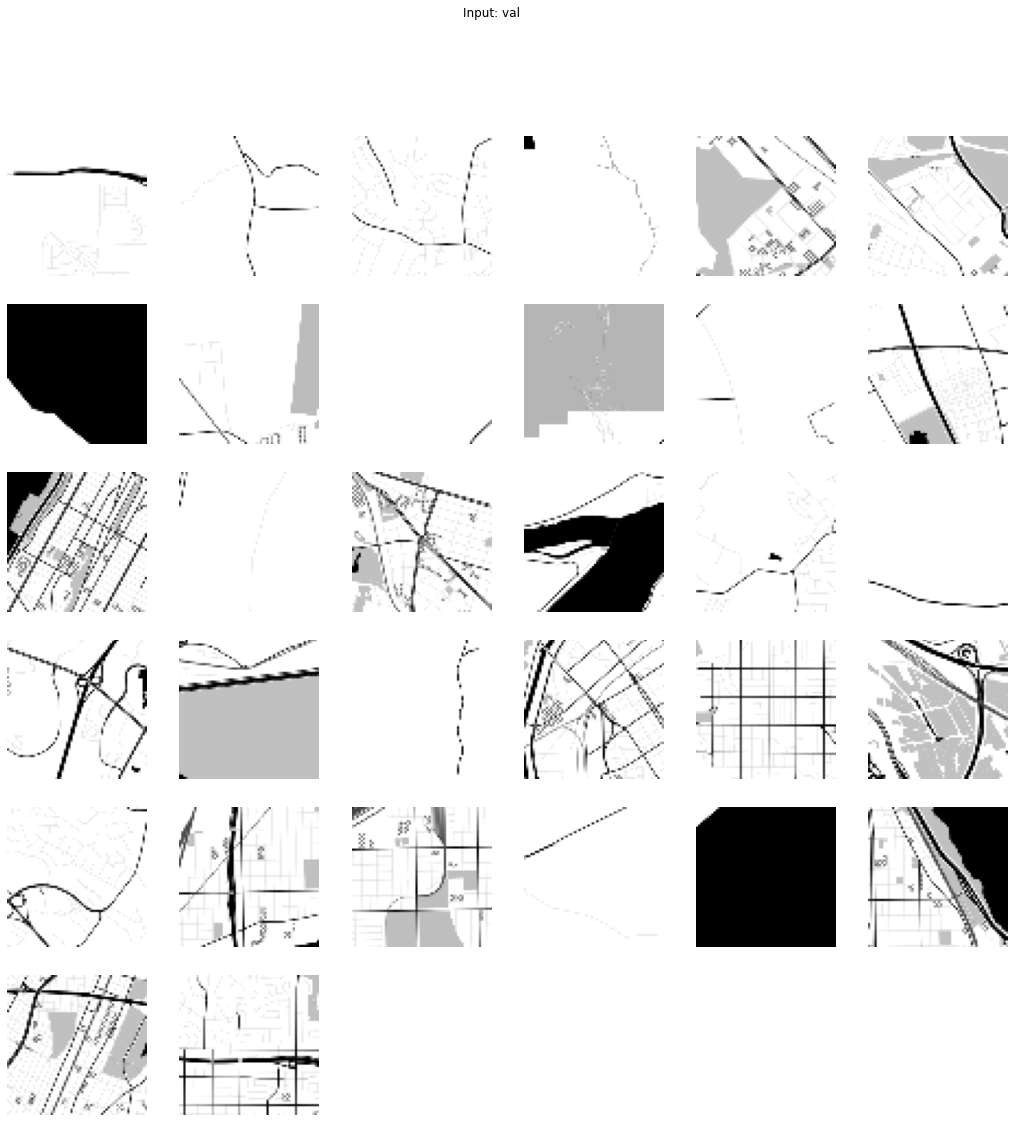

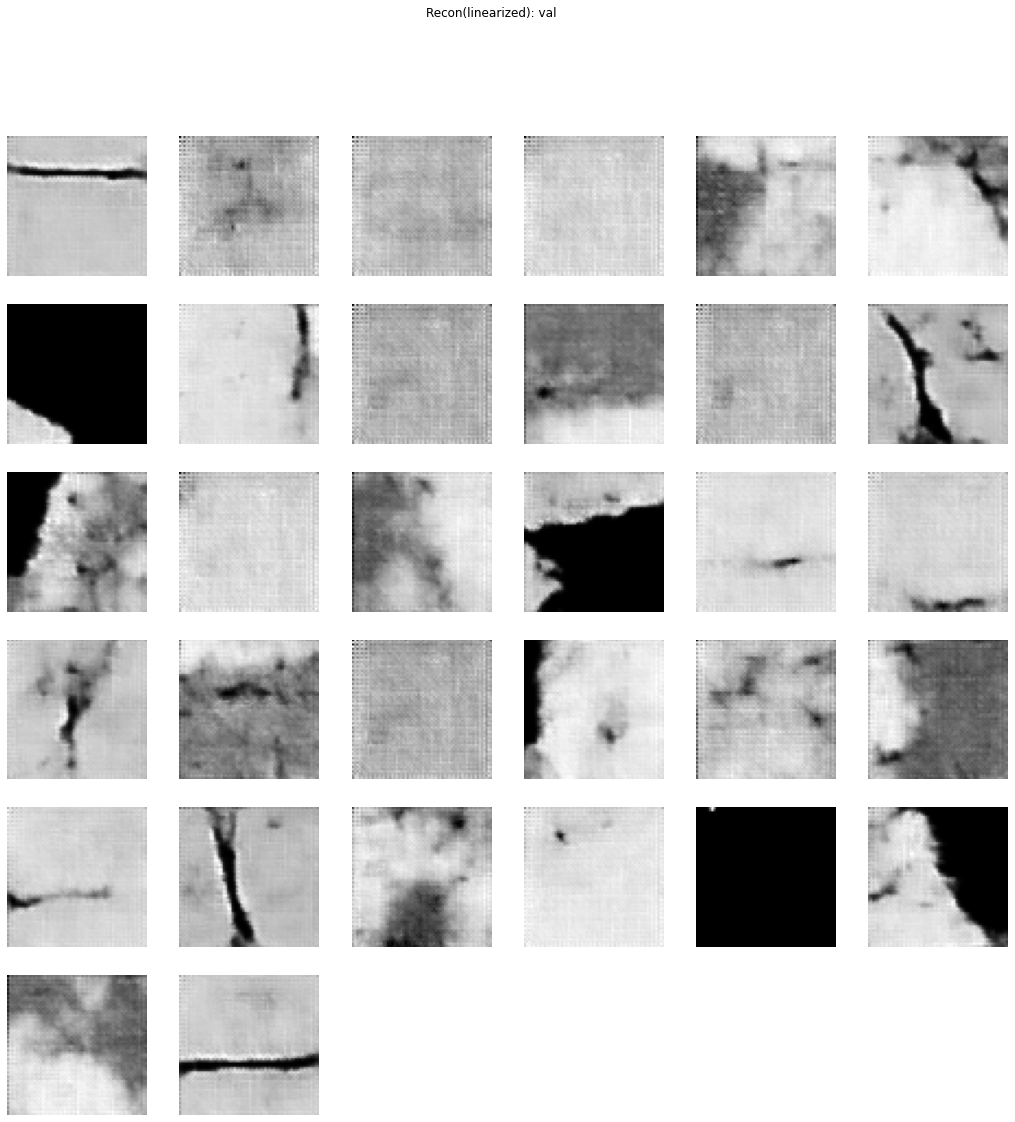

In [28]:
show_recon(model, tb_logger.experiment, global_step=1, verbose=True)

## Separation of content vs. style in the latent space

- Case 1: Take two inputs of same content (digit id) and very different colorization styles
- Case 2: Take two inputs of different contents (eg. digit 0 and digit 5)
    - First, pass the first image to encoder -> get c^(1) and s^(1)
    - Now pass the second image to encoder -> get c^(2) and s^(2)
    - recon1 = decoder(z=[c^(1), s^(1)])
    - recon2 = decoder(z=[c^(2), s^(1)])
    - ---
    - recon3 = decoder(z=[c^(1), s^(2)])
    - recon4 = decoder(z=[c^(2), s^(2)])
---
Do it for a dataset from multiple styles
- Create a concatenated dataseta

### Collect one image per digit id to create a fixed evaluation image set
Save the test image set to compare different models 

In [ ]:
from torch.utils.data import Sampler
# See https://github.com/pytorch/pytorch/blob/master/torch/utils/data/sampler.py

class DeterministicSampler(Sampler):

    def __init__(self, dataset, seed:int):
        self.dataset = dataset
        self.seed = seed
        self.generator = torch.Generator()
        self.generator.manual_seed(self.seed)
        self.indices = torch.randperm(len(self.dataset), generator=self.generator).tolist()

    def __iter__(self):
        yield from torch.randperm(len(self.dataset), generator=self.generator).tolist()
#         return iter(self.indices) #  yield from iter(self.indices)

def test_deterministic_sampler():
    seeded_sampler = DeterministicSampler(ds, seed=10)
    for i in range(10):
        ind = next(iter(seeded_sampler))
        print(ind)

In [ ]:
def get_class_reps(dl: DataLoader) -> Dict[Union[str,int], torch.Tensor]:
    class_reps = {}
    for i in range(len(dl.dataset)):
        batch = dl.dataset[i]
        x = batch['img']
        label_c = batch['digit']  # digit/content label (int) -- currently not used
        label_s = batch['color']

        if len(class_reps) >= 10:
            break
        if isinstance(label_c, torch.Tensor):
            label_c = label_c.item()
        label_c = str(label_c)
        if label_c in class_reps:
            continue
        class_reps[label_c] = x
    return class_reps

def create_mnistm_class_reps(to_save=True) -> Dict[str, torch.Tensor]:
    """todo: make it compatible with other datamodules"""
    mode = 'train'
    dm = MNISTMDataModule(data_root=data_root, in_shape=in_shape, batch_size=36,
                         shuffle=True)
    dm.setup()
    train_mean, train_std = dm.train_mean, dm.train_std

    dl = getattr(dm, f"{mode}_dataloader")()
    class_reps = get_class_reps(dl)

    # Show original digit images (one for each class, ie. "representatives" of each digit id)
    timgs = torch.stack(tuple(class_reps.values()))
    unnormed = unnormalize(timgs, dm.train_mean, dm.train_std)
    show_timgs(unnormed, nrows=2)
    print(class_reps.keys())
    
    if to_save:
        out_dir = ROOT/'data/test-transfers'
        out_dir.mkdir(parents=True, exist_ok=True)
        out_path = out_dir/f'class_reps_{now2str()}'
        print("Saved class_reps to: ", out_path)
        joblib.dump(class_reps, out_path)
    return class_reps

In [ ]:
# class_reps = create_mnistm_class_reps()


In [ ]:
mode = 'train'
dl = getattr(dm, f"{mode}_dataloader")()
class_reps = get_class_reps(dl)

### Case 1: constant content code $c$, varying style code $s^{(i)} \in \{s^{(1)}, \dots \}$
  - $z = [c, s^{(i)}]$ --> decoder --> $\mu^{x^{(i)}}_{pred}$ (aka. recon)

First, we fix the content code to that of a constant input (eg. an ith datapt in the training set),
and use various style codes (eg. any $j \neq i$th datapt). We combine the (constant) content code with each of the style code and see the output of the decoder (ie. `mu_x_pred`).

In [ ]:
# Reconstruct each digit-representative image by 
# interlacing a single content code with various style codes
linearlize = True
model.eval()
train_mean, train_std = dm.train_mean, dm.train_std
ids = [str(i) for i in range(10)]
grids = {} 
for i, id_a in enumerate(ids):
    
    grids[id_a] = []
    for j, id_b in enumerate(ids):

        img_a = class_reps[id_a]
        img_b = class_reps[id_b]
        img_pair = torch.stack([img_a, img_b], dim=0)
        unnormed_img_pair = unnormalize(img_pair, train_mean, train_std)
        
        with torch.no_grad():
            dict_qparams = model.encode(img_pair)
            dict_z = model.rsample(dict_qparams)
    #         pprint(dict_z)

            # Fix content to c[0]
            content = dict_z["c"][[0]]
            style = dict_z["s"][[1]]
            test_dict_z = {"c": content, "s": style}
    #         pprint(test_dict_z)

            # Reconstruct
            z = model.combine_content_style(test_dict_z)
            recons = model.decode(z)

            # Optional: for better viz, unnormalize or/and linearlize
            unnormed_recons = unnormalize(recons, train_mean, train_std)
            if linearlize:
                img_pair = LinearRescaler()(img_pair)
                unnormed_recons = LinearRescaler()(unnormed_recons)
#             info(recons, 'recons')
#             info(unnormed_recons, 'unnormed_recons')    
            
            grid = torchvision.utils.make_grid(
                torch.cat([unnormed_img_pair,unnormed_recons], dim=0)
            ) # (3, gridh, gridw)
            grids[id_a].append(grid)

# Concatenate the grids to make a single grid by putting each grid in row dim(ie. dim=1)    #log_dir/content_transfers/version_x
# -- Optionally, save the image results    
log_dir = Path(model.logger.log_dir)
save_dir = get_next_version_path(log_dir, name='content_transfers') 
save_dir.mkdir()
print("Created: ", save_dir)

for id_a, recons in grids.items():
    recons = torch.cat(recons, dim=1)
    save_path = save_dir/f"content_transfers_{id_a}.png"
    show_timg(recons, 
              title=id_a, 
              save_path=save_path,
             )
    plt.axis('off')
    plt.show()
    

### Case 2: fix the style code, and apply the style to various contents.
We have a single stlye code provider, and multiple content providers.
- We first extract the style code $s$ from the style provider
- Then, for each content provider x^{(i)}, extract the content code $c^{(i)}$
- Combine the constant style code with each content code and pass into the decoder.

Ideal result will show that each reconstructed image preserves the content of each content provider, while stylizing the content in the style of the style provider.


In [ ]:
# Viz options
linearlize = True

# Reconstruct each digit-representative image by 
# interlacing a single content code with various style codes
model.eval()
ids = [str(i) for i in range(10)]
grids = {} 
for i, id_a in enumerate(ids):
    
    grids[id_a] = []
    for j, id_b in enumerate(ids):

        img_a = class_reps[id_a]
        img_b = class_reps[id_b]
        img_pair = torch.stack([img_a, img_b], dim=0)
        unnormed_img_pair = unnormalize(img_pair, train_mean, train_std)
        
        with torch.no_grad():
            dict_qparams = model.encode(img_pair)
            dict_z = model.rsample(dict_qparams)
    #         pprint(dict_z)

            # Fix style to s[0]
            style = dict_z["s"][[0]]
            content = dict_z["c"][[1]]
            test_dict_z = {"c": content, "s": style}

            # Reconstruct
            z = model.combine_content_style(test_dict_z)
            recons = model.decode(z)
            
            # Optional: for better viz, unnormalize or/and linearlize
            unnormed_recons = unnormalize(recons, train_mean, train_std)
            if linearlize:
                img_pair = LinearRescaler()(img_pair)
                unnormed_recons = LinearRescaler()(unnormed_recons)
#             info(recons, 'recons')
#             info(unnormed_recons, 'unnormed_recons')    
            
            # Make a grid of [input pairs, reconstructed image of the mixed codes]
            grid = torchvision.utils.make_grid(
                torch.cat([unnormed_img_pair,unnormed_recons], dim=0)
            ) # (3, gridh, gridw)
            grids[id_a].append(grid)

# Concatenate the grids to make a single grid by putting each grid in row dim(ie. dim=1)    #log_dir/content_transfers/version_x
# -- Optionally, save the image results    
log_dir = Path(model.logger.log_dir)
save_dir = get_next_version_path(log_dir, name='style_transfers') 
save_dir.mkdir()
print("Created: ", save_dir)

for id_a, recons in grids.items():
    recons = torch.cat(recons, dim=1)
    save_path = save_dir/f"style_transfers_{id_a}.png"
    show_timg(recons, 
              title=id_a, 
              save_path=save_path,
             )
    plt.axis('off')
    plt.show()

todo
- [x] Get the version code from pl.log
- [ ] Make logger for loss_c and loss_s
- [ ] Impl. evaluation code


Here
- [ ] Impl. code for latent space traversal
- [ ] Look at the embeddings based on z_c
  - any clusters? -- run kmeans
    - use digit id as labels in TB Projector
- [ ] Look at the embeddings based on z_s
  - any clusters? does it match clusters based on style class? 
    - use style id as labels
    
---
Experiment adv vae model on maptiles
- [ ] Train a model with maptiles w/ one style
- [ ] Train a model with maptiles w/ two style (eg. tonerbackground, cartolight)

### Latent space 
- Embeddings (cluster, Nearest neighbor)
  - Content space: clustering, NNeighbor queries
  - Style space: clustering, NNeighbor queries
- Distribution of qc's parameters
- Distribution of qs's parameters


#### Visualize embeddings
- collect a batch of inputs -> encoder -> [mu, log_var] -> sample -> a batch of z's (embeddings)
- use tb logger


In [ ]:
ckpt_path = trainer.checkpoint_callback.best_model_path
ckpt = pl_load(ckpt_path, map_location=lambda storage, loc: storage) #dict object
model.load_state_dict(ckpt['state_dict'])
best_global_step = ckpt['global_step']
for k,v in ckpt.items():
    if 'state' in k:
        continue
    pprint(f"{k}:{v}")

In [ ]:
model.eval()
# best_epoch = ckpt["epoch"]

ds = model.train_dataloader().dataset
dl = DataLoader(ds, batch_size=1028)
with torch.no_grad():
#     x, y = next(iter(model.train_dataloader()))
    x, y = next(iter(dl))
    dict_qparams = model.encode(x)
    dict_z = model.rsample(dict_qparams)
    
#     z = out['z']
    
    # log embedding of z_c to tensorboard 
    writer = model.logger.experiment
    writer.add_embedding(dict_z['c'],
                         label_img=LinearRescaler()(x), 
                         metadata=y.tolist(),
                         global_step=best_global_step, #todo
                         tag="z_c"
                        )
    
    # log embedding of z_s to tensorboard 
    writer = model.logger.experiment
    writer.add_embedding(dict_z['s'],
                         label_img=LinearRescaler()(x), 
                         metadata=y.tolist(),
                         global_step=best_global_step, #todo
                         tag="z_s"
                        )
    
    



In [ ]:
todo:
    project many more (Eg. the whole dataset) to embeddings
    

### Visualize original images of the close neighbors in the latent space
- Compute pairwise distance using cosine similarity
- For each row (ie. a latent code), get the index of the smallest values. 
- Select the images in the batch x and visualize (can do this all in show_timgs)



In [ ]:
from sklearn.metrics import pairwise_distances

In [ ]:
model.eval()
mode = 'train'
query_size = 64 #1024
metric = 'cosine' #pairwise distance metric in content space
ds = getattr(dm, f"{mode}_ds")
dl = DataLoader(ds, batch_size=query_size, shuffle=True)
with torch.no_grad():
    batch = next(iter(dl))
    
    x = batch['img']
    y = batch['digit']  # digit/content label (int) -- currently not used
#     label_s = batch['color']
    dict_qparams = model.encode(x)
    dict_z = model.rsample(dict_qparams)
    c = dict_z['c']
    s = dict_z['s']
    z = model.combine_content_style(dict_z)

    for name, embedding in zip(["c", "s", "z"], [c,s,z]):
        # Compute pairwise distance of the embeddings
        pdists = pairwise_distances(embedding.numpy(), metric=metric)
        plt.imshow(pdists, cmap='gray')
        plt.title(f"Pairwise dists of {name}'s")
        plt.axis('off')
        plt.show()

        # smaller values means closer in distance
        n_ngbrs = 10
        n_rows = query_size #100

        selected_rows = range(len(x)) #np.random.choice(len(x), size=n_rows)
        for idx in selected_rows:
            args = np.argsort(pdists[idx])[:n_ngbrs]
    #         print(args)
            show_timgs(LinearRescaler()(x[args]), cmap='gray', factor=2, 
                       nrows=1, title=f'Nearest of digit {y[idx].item()}: {name}')

#### Latent partition via. distribution of q's parameters
1. Distribution of qc's parameters per digit_id
2. Distribution of qs's parameters per style label

Step:
- Input a batch of input images of the same content (ie. digit_id), 
- Get the distribution of its $mu^{(c)}_j$'s at each of its dimensions $j$

In [ ]:
from src.visualize.utils import get_fig

In [ ]:
# # Collect a batch of images of the same content
# digit_id = 0
# n_samples = 128
# xs = []
# n_collected = 0
# while n_collected <= n_samples:
#     (x,y) = next(iter(dl))
#     selected = x[y==digit_id]
#     xs.append(selected)
#     n_collected += len(selected)
# xs = torch.cat(xs, dim=0)
# print(f" Digit {digit_id} collected. Input: {xs.shape}")

# # Set output dir
# out_dir = model.logger.log_dir/"dist-qparams"

# # Plot the distributions of qc parameters and qs parameters
# model.eval()
# with torch.no_grad():
#     dict_qparams = model(xs)
    
#     # Dist. of each content dim's parameters
#     mu_qc, var_qc = dict_qparams['mu_qc'], dict_qparams['logvar_qc'].exp() #(BS, content_dim), (BS, style_dim)
#     f, ax = plt.subplots(1, model.content_dim, figsize=(20,2))
#     title = f"Digit {digit_id}: " + r"Dist. of $mu^{c}_j$"
#     f.suptitle(title)
#     for j in range(model.content_dim):
#         ax[j].hist(mu_qc[:,j])
#         ax[j].set_xlim((-4,4))
#         ax[j].set_title(f"dim {j}")
#     f.tight_layout()
#     plt.show()
#     f.savefig(out_dir/f"digit-{digit_id}-mu_qc.png" 
    
#     # Dist. of each style dim's parameters
#     mu_qs, var_qs = dict_qparams['mu_qs'], dict_qparams['logvar_qs'].exp()
#     f, ax = plt.subplots(1, model.style_dim, figsize=(20,2))
#     title = f"Digit {digit_id}: " + r"Dist. of $mu^{s}_j$"
#     f.suptitle(title)
#     for j in range(model.style_dim):
#         ax[j].hist(mu_qs[:,j])
#         ax[j].set_xlim((0,2))
#         ax[j].set_title(f"dim {j}")
#     f.tight_layout()
#     plt.show()

In [ ]:
var_qc.max().item()

In [ ]:
mu_xlim = (-4., 4.)
# var_xlim = (0, 0.05)
n_samples = 1024
# Set output dir
out_dir = log_dir/"dist_qparams"
if not out_dir.exists():
    out_dir.mkdir(parents=True)
    print("Created and saving to: ", out_dir)
    
for digit_id in range(10):
    # Collect a batch of images of the same content
    xs = []
    n_collected = 0
    while n_collected <= n_samples:
        batch = next(iter(dl))
        x = batch['img']
        label_c = batch['digit']
        label_s = batch['color']
        selected = x[label_c==digit_id]
        xs.append(selected)
        n_collected += len(selected)
    xs = torch.cat(xs, dim=0)
    print(f" Digit {digit_id} collected. Input: {xs.shape}")


    # Plot the distributions of qc parameters and qs parameters
    model.eval()
    with torch.no_grad():
        dict_qparams = model(xs)

        # Dist. of each content dim's parameters
        mu_qc, var_qc = dict_qparams['mu_qc'], dict_qparams['logvar_qc'].exp() #(BS, content_dim), (BS, style_dim)
        # -- mu_qc's
#         mu_xlim = (0, max(mu_qc)
        f, ax = plt.subplots(1, model.content_dim, figsize=(20,2))
        title = f"Digit {digit_id}: " + r"Dist. of $mu^{c}_j$"
        f.suptitle(title)
        for j in range(model.content_dim):
            ax[j].hist(mu_qc[:,j])
            ax[j].set_xlim(mu_xlim)
            ax[j].set_title(f"dim {j}")
        f.tight_layout()
        f.savefig(out_dir/f"digit-{digit_id}-mu_qc.png")
        plt.show()
        
        # -- var_qc's
        var_xlim = (0, var_qc.max().item())
        f, ax = plt.subplots(1, model.style_dim, figsize=(20,2))
        title = f"Digit {digit_id}: " + r"Dist. of $var^{c}_j$"
        f.suptitle(title)
        for j in range(model.content_dim):
            ax[j].hist(var_qc[:,j])
            ax[j].set_xlim(var_xlim)
            ax[j].set_title(f"dim {j}")
        f.tight_layout()
        f.savefig(out_dir/f"digit-{digit_id}-var_qc.png")
        plt.show()

        
        # Dist. of each style dim's parameters
        mu_qs, var_qs = dict_qparams['mu_qs'], dict_qparams['logvar_qs'].exp()
        # -- mu_qs's
#         mu_xlim = (0, max(mu_qs))
        f, ax = plt.subplots(1, model.style_dim, figsize=(20,2))
        title = f"Digit {digit_id}: " + r"Dist. of $mu^{s}_j$"
        f.suptitle(title)
        for j in range(model.style_dim):
            ax[j].hist(mu_qs[:,j])
            ax[j].set_xlim(mu_xlim)
            ax[j].set_title(f"dim {j}")
        f.tight_layout()
        f.savefig(out_dir/f"digit-{digit_id}-mu_qs.png")
        plt.show()
        
        # -- var_qs's
        var_xlim = (0, var_qs.max().item())
        f, ax = plt.subplots(1, model.style_dim, figsize=(20,2))
        title = f"Digit {digit_id}: " + r"Dist. of $var^{s}_j$"
        f.suptitle(title)
        for j in range(model.style_dim):
            ax[j].hist(var_qs[:,j])
            ax[j].set_xlim(var_xlim)
            ax[j].set_title(f"dim {j}")
        f.tight_layout()
        f.savefig(out_dir/f"digit-{digit_id}-var_qs.png")
        plt.show()

In [ ]:
plt.bar(var_qs)

---
## Test BiVAE implementation 

TODO:
- [ ] Check output sizes of BiVAE's 
    - [x] encode
    - [x] rsample
    - [x] combine_content_and_style
    - [x] decode
    - [x] forward
- [ ] Check losses 

In [ ]:
x,y = next(iter(dm.train_dataloader()))
info(x), info(y)

- check `encode` and `rsample`

In [ ]:
dict_qparams = model.encode(x)
for k,v in dict_qparams.items():
    print(f"\n{k}:  {v.shape}")
    if 'mu' in k:
        print(v[0])
    else:
        print(v[0].exp())

In [ ]:
dict_z = model.rsample(dict_qparams)
for k,v in dict_z.items():
    print(f"\n{k}:  {v.shape}")
    print(v[0])

- check `combine_content_style` and `decode`

In [ ]:
z = model.combine_content_style(dict_z)
assert z.shape == (batch_size, latent_dim)
print("z shape: ", z.shape) #(BS, latent_dim)

In [ ]:
mu_x_pred = model.decode(z)
assert mu_x_pred.shape == (batch_size, *in_shape)
print("mu_x_pred shape: ", mu_x_pred.shape)

- Check the entire forward pass

In [ ]:
out_dict  = model(x)
for k,v in out_dict.items():
    print(f"\n{k}:  {v.shape}")


- Check the component's of the optimization objective (ie. loss)
    - [x] partition_z: z -> dict_z (keys are "c" and "s")
    - [ ] predict_y: z_partition -> scores
    - [ ]

In [ ]:
dict_z = model.partition_z(z)
for k,v in dict_z.items():
    print(f"{k}: {v.shape}")
    assert v.shape == (batch_size, model.content_dim)

In [ ]:
c,s = dict_z["c"], dict_z["s"]
c.shape, s.shape

TODO: 
- [ ] Showing the changes in the scores based on c and scores based on s will be super intersting to see as the model learns!!!

In [ ]:
scores_c = model.predict_y(c)
scores_s = model.predict_y(s)
assert scores_c.shape == (batch_size, model.n_classes)
assert scores_s.shape == (batch_size, model.n_classes)

print(scores_c[0]) # TODO: Showing the changes in the scores based on c and scores based on s will be super intersting to see as the model learns!!!
print(scores_s[0])

In [ ]:
y[0]

- check `compute_loss_c` and `compute_loss_s`


In [ ]:
loss_c = model.compute_loss_c(c)
print("loss_c: ", loss_c)

In [ ]:
loss_s = model.compute_loss_s(s, y)
print("loss_s: ", loss_s)

- Full loss workflow

In [ ]:
out_dict = model(x)
loss_dict = model.loss_function(out_dict, [x,y], 'train')
pprint(loss_dict)

In [ ]:
a = torch.ones((5,2))
b = torch.zeros((5,3))

In [ ]:
torch.cat([a,b], dim=1)

In [ ]:
m = nn.LogSoftmax()
m(a).exp()

---

## Play with MNISTM and USPS datasets

- MNISTM
    - original size of an image: (1, 16,16)
    - labels: {0, ..., 9}
- USPS
    - original size of an image: (3, 28, 28)
    - labels" {0, ..., 9}
    

In [ ]:
from src.data.datasets.mnistm import MNISTM
from torchvision.datasets import USPS


In [ ]:
# MNISTM Dataset
bs = 16
num_workers = 16
pin_memory = True
xforms = transforms.Compose([
    transforms.ToTensor(),
    ])
# target_xforms = 
ds = MNISTM(ROOT/'data', 
          transform=xforms,
          download=True)

dl = DataLoader(ds, batch_size=bs, shuffle=True, 
               num_workers=num_workers, pin_memory=pin_memory)


x,y = next(iter(dl))
info(x)
info(y)

In [ ]:
show_timgs(x)

In [ ]:
# USPS Dataset
bs = 16
num_workers = 16
pin_memory = True
xforms = transforms.Compose([
    transforms.ToTensor(),
    ])
# target_xforms = 
ds = USPS(ROOT/'data', 
          transform=xforms,
          download=True)

dl = DataLoader(ds, batch_size=bs, shuffle=True, 
               num_workers=num_workers, pin_memory=pin_memory)


x,y = next(iter(dl))
info(x)
info(y)
show_timgs(x, cmap='gray')